In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn import preprocessing, svm
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import LinearRegression
from IPython.display import HTML, display

## Data loading

In [2]:


dfImages = pd.read_csv('../data/IAPS.csv',
                       sep=';',
                       usecols=['IAPS', 'ValenceMean', 'ArousalMean']
                      )



dfSounds = pd.read_csv('../data/IADS2.csv', sep=';', usecols=['Number', 'ValenceMean', 'ArousalMean'])


studyDatafiles = glob.glob('../data/procedura/*.txt')

li = []

for filename in studyDatafiles:
    df = pd.read_csv(filename, sep='\t', header=None, names=['ID', 'nn', 'Condition', 'SpecificCondition', 'Number', 'IAPS', 'Widget', 'Response', 'Delay', 'ApperanceTimestamp'])
    li.append(df)
                         
dfStudy = pd.concat(li, axis=0, ignore_index=True)

dfStudy = dfStudy[dfStudy.Condition != 'con']
dfStudy = dfStudy[dfStudy.Widget != 'emoscale1']
                                     


## Preprocessing

In [3]:


dfStudy['Number'] = pd.to_numeric(dfStudy['Number'])



def convertResponseStringIntoColumns(string):
    string = string[1:-1]
    array = (string.split(','))
    array[0] = float(array[0]) * 10
    array[1] = float(array[1][1:]) * 10
    return array

def findExpectedImageReaction(iaps):
    valence = dfImages[dfImages.IAPS == str(iaps)].ValenceMean.tolist()
    arousal = dfImages[dfImages.IAPS == str(iaps)].ArousalMean.tolist()
    
    return [sum(valence)/len(valence), sum(arousal)/len(arousal)] if valence else [np.nan, np.nan]

def findExpectedSoundReaction(number):
    valence = dfSounds[dfSounds.Number == number].ValenceMean.tolist()
    arousal = dfSounds[dfSounds.Number == number].ArousalMean.tolist()
    
    return [sum(valence)/len(valence), sum(arousal)/len(arousal)] if valence else [np.nan, np.nan]

def applySpecificCondition(condition, i):
    if (condition[1] == '-' and i == 0) or (condition[3] == '-' and i == 1):
        return -1
    else:
        return 1

def labelReaction(valence):
    return 1 if valence < 0 else -1

    
def getValence(array):
    return array[0]

def getArousal(array):
    return array[1]
    
dfStudy['ActualReaction'] = dfStudy.Response.apply(func = convertResponseStringIntoColumns)

dfStudy['ExpectedImageReaction'] = dfStudy.IAPS.apply(findExpectedImageReaction)
dfStudy['ExpectedSoundReaction'] = dfStudy.Number.apply(findExpectedSoundReaction)
       
dfStudy['ImageCondition'] = dfStudy.SpecificCondition.apply(applySpecificCondition, i = 0)
dfStudy['SoundCondition'] = dfStudy.SpecificCondition.apply(applySpecificCondition, i = 1)

dfStudy['ImageValence'] = dfStudy.ExpectedImageReaction.apply(getValence)
dfStudy['ImageArousal'] = dfStudy.ExpectedImageReaction.apply(getArousal)
dfStudy['SoundValence'] = dfStudy.ExpectedSoundReaction.apply(getValence)
dfStudy['SoundArousal'] = dfStudy.ExpectedSoundReaction.apply(getArousal)
dfStudy['ActualValence'] = dfStudy.ActualReaction.apply(getValence)
dfStudy['ActualArousal'] = dfStudy.ActualReaction.apply(getArousal)
dfStudy['Label'] = dfStudy.ActualValence.apply(labelReaction)

df = dfStudy[['ImageCondition',
              'ImageValence',
              'ImageArousal',
              'SoundCondition',
              'SoundValence',
              'SoundArousal',
              'ActualValence',
              'ActualArousal',
              'Label'
             ]]
df = df.dropna()
df.head()


,ImageCondition,ImageValence,ImageArousal,SoundCondition,SoundValence,SoundArousal,ActualValence,ActualArousal,Label
0,-1,1.91,5.60,1,6.47,7.32,0.843677,1.573651,-1
3,1,6.27,6.06,-1,2.04,6.87,-4.317224,1.926666,1
4,1,5.89,6.21,-1,1.63,7.79,-0.771283,2.728180,1
6,1,6.44,7.07,-1,2.22,7.52,0.085718,3.900079,-1
7,1,6.22,6.62,-1,1.65,7.61,-3.004779,3.631299,1


## Regression Model



In [17]:


x = df[['ImageCondition', 'ImageValence', 'ImageArousal',
        'SoundCondition', 'SoundValence', 'SoundArousal']]
    
y = df[['Label']]

reg = LinearRegression(n_jobs=-1)
X = np.array(x)
Y =  np.array(y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
reg.fit(X_train, Y_train)
print('Image Condition ImageValence ImageArousal SoundCondition SoundValence SoundArousal ||Label')
print(reg.score(X_test, Y_test))
print(reg.coef_)


      






Image Condition ImageValence ImageArousal SoundCondition SoundValence SoundArousal ||Label
0.10918272665396922
[[-1.24636471  0.35398222 -0.1607351   1.24636471 -0.67549291  0.01478531]]


AttributeError: 'LinearRegression' object has no attribute 'model'

<Figure size 1440x864 with 0 Axes>

In [5]:


reg = LinearRegression(n_jobs=-1)
X = df[['ImageCondition', 'ImageValence', 'ImageArousal',
        'SoundCondition', 'SoundValence', 'SoundArousal']]
Y =  df[['ActualValence', 'ActualArousal']]
reg.fit(X, Y)
print('Image Condition ImageValence ImageArousal SoundCondition SoundValence SoundArousal || ActualValence || ActualArousal')
print(reg.score(X, Y))
print(reg.coef_)
    
      
      
X = df[['ImageValence', 'ImageArousal',
        'SoundValence', 'SoundArousal']]     
Y = df[['ActualValence', 'ActualArousal']]

reg.fit(X, Y)

print('ImageValence ImageArousal SoundValence SoundArousal || ActualValence || ActualArousal')
print(reg.score(X, Y))
print(reg.coef_)

      
      
X = df[['ImageCondition', 'ImageValence',
        'SoundCondition', 'SoundValence']]
Y = df['ActualValence']
reg.fit(X, Y)

print('ImageCondition ImageValence SoundCondition SoundValence || ActualValence')
print(reg.score(X, Y))
print(reg.coef_)

      
X = df[['ImageValence',
        'SoundValence']]
Y = df['ActualValence']
reg.fit(X, Y)

print('ImageValence SoundValence || ActualValence')
print(reg.score(X, Y))
print(reg.coef_)


      
X = df[['ImageCondition', 'ImageArousal',
        'SoundCondition', 'SoundArousal']]
Y = df['ActualArousal']
reg.fit(X, Y)

print('ImageCondition ImageArousal SoundCondition SoundArousal || ActualArousal')
print(reg.score(X, Y))
print(reg.coef_)

      
X = df[['ImageArousal',
        'SoundArousal']]
Y = df['ActualArousal']
reg.fit(X, Y)

print('ImageArousal SoundArousal || ActualArousal')
print(reg.score(X, Y))
print(reg.coef_)





Image Condition ImageValence ImageArousal SoundCondition SoundValence SoundArousal || ActualValence || ActualArousal
0.12166793668346895
[[ 4.51016952 -0.59146393  0.82401674 -4.51016952  3.06597205  0.23227946]
 [-0.53123328 -0.14294641  0.42247949  0.53123328 -0.48367879  0.70934449]]
ImageValence ImageArousal SoundValence SoundArousal || ActualValence || ActualArousal
0.1208160631837963
[[ 1.70079038  0.8088175   1.18945502  0.17757559]
 [-0.41294109  0.42426974 -0.262652    0.71578783]]
ImageCondition ImageValence SoundCondition SoundValence || ActualValence
0.19640245193025607
[ 3.319829   -0.05649586 -3.319829    2.49296978]
ImageValence SoundValence || ActualValence
0.19550875745051655
[1.63568656 1.11984701]
ImageCondition ImageArousal SoundCondition SoundArousal || ActualArousal
0.023551183225475447
[-0.22222942  0.45323944  0.22222942  0.89041624]
ImageArousal SoundArousal || ActualArousal
0.014775004819475246
[0.57706722 0.6971077 ]


In [6]:


reg = LinearRegression(n_jobs=-1)
X = np.array(df[['ImageCondition', 'ImageValence', 'ImageArousal',
        'SoundCondition', 'SoundValence', 'SoundArousal']])
Y =  np.array(df[['ActualValence', 'ActualArousal']])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
reg.fit(X_train, Y_train)
print('Image Condition ImageValence ImageArousal SoundCondition SoundValence SoundArousal || ActualValence || ActualArousal')
print(reg.score(X_test, Y_test))
print(reg.coef_)
    
      
      
X = np.array(df[['ImageValence', 'ImageArousal',
        'SoundValence', 'SoundArousal']])     
Y = np.array(df[['ActualValence', 'ActualArousal']])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
reg.fit(X_train, Y_train)

print('ImageValence ImageArousal SoundValence SoundArousal || ActualValence || ActualArousal')
print(reg.score(X_test, Y_test))
print(reg.coef_)

      
      
X = np.array(df[['ImageCondition', 'ImageValence',
        'SoundCondition', 'SoundValence']])
Y = np.array(df['ActualValence'])
reg.fit(X_test, Y_test)

print('ImageCondition ImageValence SoundCondition SoundValence || ActualValence')
print(reg.score(X_test, Y_test))
print(reg.coef_)

      
X = np.array(df[['ImageValence',
        'SoundValence']])
X = preprocessing.scale(X)
Y = np.array(df['ActualValence'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
reg.fit(X_train, Y_train)

print('ImageValence SoundValence || ActualValence')
print(reg.score(X_test, Y_test))
print(reg.coef_)


      
X = np.array(df[['ImageCondition', 'ImageArousal',
        'SoundCondition', 'SoundArousal']])
Y = np.array(df['ActualArousal'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
reg.fit(X_train, Y_train)

print('ImageCondition ImageArousal SoundCondition SoundArousal || ActualArousal')
print(reg.score(X_test, Y_test))
print(reg.coef_)

      
X = np.array(df[['ImageArousal',
        'SoundArousal']])
Y = np.array(df['ActualArousal'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
reg.fit(X_train, Y_train)

print('ImageArousal SoundArousal || ActualArousal')
print(reg.score(X_test, Y_test))
print(reg.coef_)





Image Condition ImageValence ImageArousal SoundCondition SoundValence SoundArousal || ActualValence || ActualArousal
0.1153108023569646
[[ 5.26556583 -1.00373067  0.75881923 -5.26556583  3.34351463  0.26912423]
 [-0.21561209 -0.33319486  0.29340734  0.21561209 -0.35371524  0.72526624]]
ImageValence ImageArousal SoundValence SoundArousal || ActualValence || ActualArousal
0.11742248987674125
[[ 1.68452174  0.7642111   1.18393585  0.19010671]
 [-0.40065818  0.47224487 -0.20762825  0.80939606]]
ImageCondition ImageValence SoundCondition SoundValence || ActualValence
0.12462123271059393
[[ 1.76929961  0.99620216  1.21904619  0.15111744]
 [-0.46375692  0.16068183 -0.49044819  0.27866256]]
ImageValence SoundValence || ActualValence
0.18219880745400382
[3.86656979 2.3088232 ]
ImageCondition ImageArousal SoundCondition SoundArousal || ActualArousal
0.022526832001329766
[1.19893819e+13 4.48957391e-01 1.19893819e+13 9.64072264e-01]
ImageArousal SoundArousal || ActualArousal
-0.00835345654441677
[

In [7]:


reg = svm.SVR(kernel='poly')

X = np.array(df[['ImageValence',
        'SoundValence']])
X = preprocessing.scale(X)
Y = np.array(df['ActualValence'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
reg.fit(X_train, Y_train)

print('ImageValence SoundValence || ActualValence')
print(reg.score(X_test, Y_test))


      
X = np.array(df[['ImageArousal',
        'SoundArousal']])
Y = np.array(df['ActualArousal'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
reg.fit(X_train, Y_train)

print('ImageArousal SoundArousal || ActualArousal')
print(reg.score(X_test, Y_test))





/home/axl/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


ImageValence SoundValence || ActualValence
0.2116600730789635


/home/axl/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


ImageArousal SoundArousal || ActualArousal
0.02173369871448516


In [26]:
olsModel = ols("""ActualValence ~ ImageCondition + ImageValence + SoundCondition + SoundValence""", data=df).fit()

HTML(olsModel.summary().as_html())

fig = plt.figure(figsize=(20,12))
fig = sm.graphics.plot_partregress_grid(olsModel, fig=fig)



In [25]:
olsModel = ols("""ActualArousal ~ ImageCondition + ImageArousal + SoundCondition + SoundArousal""", data=df).fit()

HTML(olsModel.summary().as_html())

fig = plt.figure(figsize=(20,12))
fig = sm.graphics.plot_partregress_grid(olsModel, fig=fig)


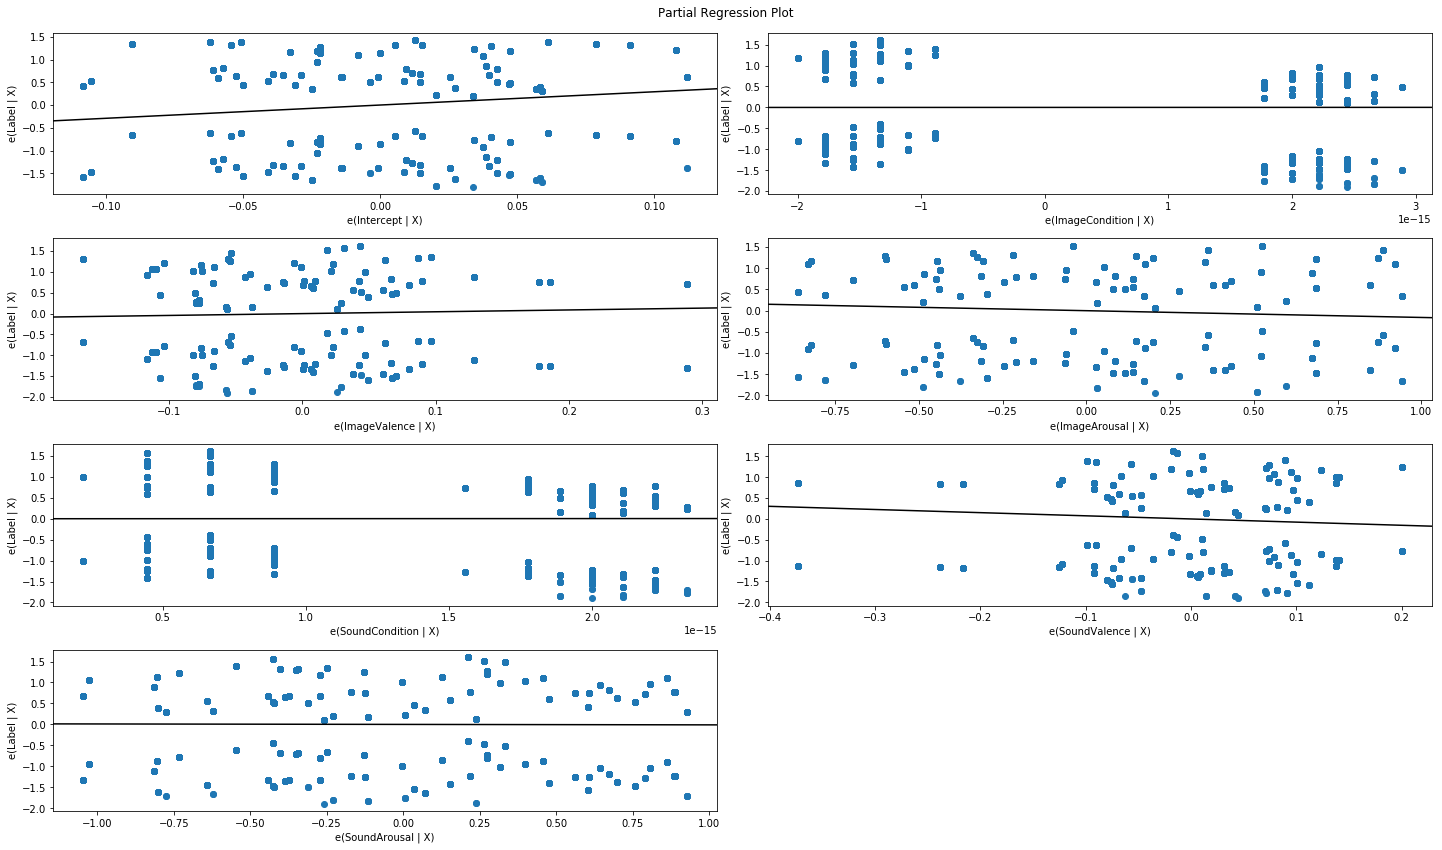

In [27]:
olsModel = ols("""Label ~ ImageCondition + ImageValence + ImageArousal + SoundCondition + SoundValence + SoundArousal""", data=df).fit()

HTML(olsModel.summary().as_html())

fig = plt.figure(figsize=(20,12))
fig = sm.graphics.plot_partregress_grid(olsModel, fig=fig)
